In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from scipy.optimize import minimize
from scipy.stats import norm

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

from weights import WeightMethod
from features import FeaturesManipulation
from linear_regression import LinReg

# Adatok betöltése és formázása

### A havi munkanélküliséget válaszottam low-frequency változónak, high-frequancy változónak pedig a napi VIX index értéketi.

A low-freq változót nem használom a tesztben, csak annyi a relevanciája, hogy az alapján lesz kiválasztva valamennyi hónap. Azért változtattam GDP-ről, mert ott a negyedéves adatokkal relatíve kevés adatpontunk lenne, és ott már az a probléma is bejöhetne. Mindezek mellett meg a negyedéves adatok esetében csak 3 lag-ot kell megbecsülnie a lag függvénynek.

In [3]:
df1 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Macroeconomic/UNEMPLOY.csv')
df1['Chg'] = np.log(df1.Value).diff().fillna(0)
df1 = FeaturesManipulation.select_timeframe(df1, datetime(1990,10,1), datetime(2020,1,1))
#df1.tail()

In [4]:
df1

,Date,Value,Chg
0,1990-10-01,7459.0,0.012275
1,1990-11-01,7764.0,0.040076
2,1990-12-01,7901.0,0.017492
3,1991-01-01,8015.0,0.014325
4,1991-02-01,8265.0,0.030715
...,...,...,...
346,2019-08-01,5999.0,-0.004657
347,2019-09-01,5753.0,-0.041871
348,2019-10-01,5857.0,0.017916
349,2019-11-01,5811.0,-0.007885


In [6]:
df2 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Macroeconomic/VIXCLS.csv')
df2 = df2[df2.VIXCLS != '.'].reset_index(drop=True)
df2.VIXCLS = df2.VIXCLS.astype(float)
df2 = df2.rename(columns = {'DATE': 'Date'})
df2['Chg'] = np.log(df2.VIXCLS).diff().fillna(0)
#df2.head()

In [7]:
df2

,Date,VIXCLS,Chg
0,1990-01-02,17.24,0.000000
1,1990-01-03,18.19,0.053640
2,1990-01-04,19.22,0.055079
3,1990-01-05,20.11,0.045266
4,1990-01-08,20.26,0.007431
...,...,...,...
7760,2020-10-22,28.11,-0.019028
7761,2020-10-23,27.55,-0.020123
7762,2020-10-26,32.46,0.164006
7763,2020-10-27,33.35,0.027049


In [8]:
df2 = FeaturesManipulation.select_timeframe(df2, df1.Date[0], df1.Date[len(df1) -1])
#df2.tail()

In [9]:
df2

,Date,VIXCLS,Chg
0,1990-10-01,28.06,-0.036737
1,1990-10-02,27.28,-0.028191
2,1990-10-03,27.90,0.022473
3,1990-10-04,27.51,-0.014077
4,1990-10-05,27.85,0.012283
...,...,...,...
7341,2019-11-22,12.34,-0.062054
7342,2019-11-25,11.87,-0.038832
7343,2019-11-26,11.54,-0.028195
7344,2019-11-27,11.75,0.018034


A modellezésnél havi 15 laggal számolok

In [5]:
X = FeaturesManipulation.compress_data(df1, df2, 'VIXCLS', lag = 15)
display(X.tail())
X = X.values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2019-08,12.93,12.39,12.68,12.86,13.97,13.53,14.45,13.53,12.61,12.07,12.74,12.16,12.83,13.94,16.12
2019-09,21.09,17.52,22.10,21.18,18.47,16.88,17.50,15.80,16.68,19.87,19.32,20.31,19.35,17.88,18.98
2019-10,15.20,14.61,14.22,13.74,14.67,14.44,13.95,14.05,15.32,14.91,17.05,15.96,16.07,17.22,16.24
2019-11,15.58,14.57,13.54,13.68,13.79,14.25,14.00,14.46,14.01,13.71,12.65,13.11,13.20,12.33,13.22
2019-12,12.07,12.69,12.68,13.00,13.05,12.05,12.46,12.86,12.78,13.13,12.34,11.87,11.54,11.75,12.62


## MIDAS modell felépítése:

Egyenlőre még a modell felírása így fest. A 'midas_filter' függvényt olyan jellegűen szeretném megcsinálni a továbbiakban, mint ahogy a tensorflowba adjuk hozzá a rétegeket, tehát mondjuk a modell felírásba akarnék adni egy Béta súlyozású magyarázó változót azt valahogy így tudnám meg tenni:
<br><br>
--> MIDAS([<br>
--> $\;\;\;\;\;\;$add.lagged_variable(változó, type = 'beta', lag = 15)<br>
--> $\;\;\;\;\;\;$...<br>
--> ])<br>

így szerintem sokkal átláthatóbb lenne a struktúrája a modellnek. Amit beszéltünk még, hogy a 'least_squares' helyett érdemesebb lenne a 'l-bfgs-b'-t használni, ehhez a négyzetes hibák összegét kell felírni mint minimalizálandó függvényt. 

***
$\mathbf{\text{Mixed Data Sampling Model}}$<br>
***
1.&emsp;A simple model: $$y_t = \beta_0 + \beta_1  B(L^\frac{1}{m}; \theta_1; \theta_2)  x^{(m)}_t + \epsilon^{(m)}_t$$
2.&emsp;Parameter Space: $$\Theta = {(\beta_0; \beta_1; \theta_1; \theta_2)}$$
3.&emsp;Sum of Squared of Errors (SSE): $$SSE(\Theta) = \epsilon^T \epsilon = \sum {(y_t - \beta_0 -\beta_1  B(L^\frac{1}{m}; \theta_1; \theta_2)  x^{(m)}_t)}^2$$
4.&emsp;Parameter optimization: $$\underset{\Theta}{\textrm{arg min}} SSE(\Theta)$$

In [6]:
def midas_filter(params, X):
    model = params[0] + params[1] * WeightMethod().x_weighted_beta(X, params[2:])
    return model

def midas_SSE(vP, y, x):
    return sum((y - midas_filter(vP, x))**2)

def midas_fit(init_params, y, x):
    res = minimize(midas_SSE, init_params, args = (y, x),
                   options = {'disp': True}, method = 'l-bfgs-b')
    return res

A véletlenre megadtam a random.seed(14)-et. Először megcsináltam a tiszta modellt, amibe nincs semmi zaj. A zajt egy N(0, 1) sztenderd normális véletlen szám biztosítja, amit hozzáadva a tiszta modellhez lett a 'y_hat' változó. Itt a zaj szórásával lehet játszadozni. A tapasztalat az, hogy minél több zajt vittem bele, annél rosszabbul tudta becsülni a Theta paramétereket. Akkor a Thetákra olyasmi jött ki, hogy az első lag relatíve magas súllyal jelenik meg a többi viszont közel azonosan. Talán erre egy jó megoldás lehetne, hogy lefixáljuk a Theta1 paramétert 1-nek és akkor innentől kezdve egy monoton csökkenő függvényt kapunk.

In [7]:
np.random.seed(14)

estimate = midas_filter([0., 1., 1., 4.], X)

eps = np.random.normal(0, 1, estimate.shape[0])
y_hat = estimate + eps

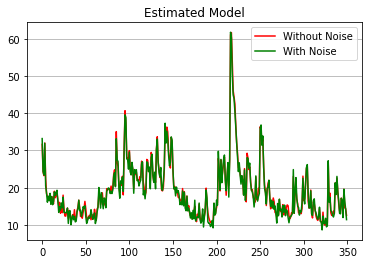

In [62]:
plt.plot(estimate, 'r', label = 'Without Noise')
plt.plot(y_hat, 'g', label = 'With Noise')
plt.title('Estimated Model')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

## Modell becslése:
Megadtam a következő kezdeti paramétereket:
$\beta_0$  = 1
$\beta_1$  = 1
$\theta_1$ = 1
$\theta_2$ = 1

Ezekkel lefutattam az optimalizálást, aminek az eredményeit ki is írattam. Az output-ban is olvasható, hogy sikeres lett az optimalizálás és a becsült paraméterek is. Azokat kiírattam, hogy jobban lássuk melyik paraméterhez milyen értéket becsült.

In [9]:
init_params = [1, 1, 1, 1]

midas_out = midas_fit(init_params, y_hat, X)
midas_out

      fun: 380.12432554635126
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.38964445e-05,  1.13686837e-04, -1.11413100e-03,  6.25277611e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 175
      nit: 24
     njev: 35
   status: 0
  success: True
        x: array([0.05288286, 0.98971184, 0.99018129, 3.64659109])

## Lag függvények:
Készítettem egy ábrát is, ahol láthatjuk a modell által becsült paraméterek milyen lag függvényt adnak ki (piros), és hogy fest az 'elméleti' lag függvényünk (zöld)

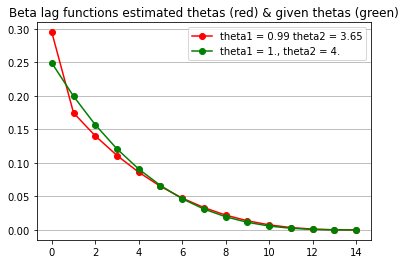

In [61]:
model_beta = WeightMethod().BetaWeights([midas_out.x[2], midas_out.x[3]], 15)

plt.plot(model_beta, 'ro-', label = 'theta1 = '+ str(round(midas_out.x[2],2)) + ' theta2 = ' + str(round(midas_out.x[3],2)))
plt.plot(WeightMethod().BetaWeights([1., 4.], 15), 'go-', label = 'theta1 = 1., theta2 = 4.')
plt.title('Beta lag functions estimated thetas (red) & given thetas (green)')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

## Becsült Paraméterek:

In [11]:
print('Estimated Parameters from MIDAS:',
    '\n\nBeta0: \t', round(midas_out.x[0], 4), 
      '\nBeta1: \t', round(midas_out.x[1], 4), 
      '\nTheta1:\t', round(midas_out.x[2], 4), 
      '\nTheta2:\t', round(midas_out.x[3], 4))

Estimated Parameters from MIDAS: 

Beta0: 	 0.0529 
Beta1: 	 0.9897 
Theta1:	 0.9902 
Theta2:	 3.6466


## Becslés Pontosságára szolgáló mutatók:

In [12]:
fit1 = midas_filter(midas_out.x, X)
print('R2 score of this model: ', round(r2(y_hat, fit1), 6))
print('MSE of this model: ', round(mse(y_hat, fit1), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit1 - np.mean(fit1))), 6))

R2 score of this model:  0.981138
MSE of this model:  1.08607
Mean Absolute Deviation (MAD) of this model:  5.550432
